# Modified Gale Shapley Algorithm for Generative Data Comparison

## Set-Up
We'll primarily using pandas to work with the data. We start off by importing pandas and importing the data as a pandas dataframe.

In [4]:
import pandas as pd

In [5]:
syndata = pd.read_csv('synData9.csv')
realdata = pd.read_csv('kag_risk_factors_cervical_cancer.csv')

In [6]:
syndata.iloc[0] #Use this to access a row
syndata.loc[0, : ] #Use this to access a row
x = syndata.loc[0,"Age"] #Use this to access a column
syndata.columns[0]

'Age'

## Data Cleaning and Helper Functions
We need to clean up the data before we use it. Primarily, this means we will need to do some normalization to the data.

One important thing we may need later on is the means for each of the columns. First, we compute mean for the raw data.

In [7]:
def mean_for_column(data1, column):
    """
    Finds the mean for a specific column
    """
    tot = 0 
    for i in range(len(data1)):
        #print(data1.loc[i, column])
        if data1.loc[i, column] == "?" or data1.loc[i, column] == -1:
            pass
        else:
            tot = tot + float(data1.loc[i, column])
    tot = tot/(len(data1))
    return tot
    
def mean_for_cols(data1):
    """
    Computes the mean for all the columns 
    """
    ar = []
    for col in data1.columns: 
        ar.append(mean_for_column(data1, col))
    return ar

In [8]:
syndata_means = mean_for_cols(syndata)
realdata_means = mean_for_cols(realdata)

clean() cleans the data by replacing any missing values and replaces them with -1 as well as changes all the datatypes to floats.

In [9]:
def clean(data1):
    """
    Replaces the missing data with a -1 value and converts the strings into floats
    """
    for i in range(len(data1)):
        for f in data1.columns:
            #print(data1.loc[i, f])
            if data1.loc[i, f] == "?":
                data1.loc[i, f] = float(-1)
                continue
            if isinstance(data1.loc[i, f], str):
                data1.loc[i, f] = float(data1.loc[i, f])
    data1 =data1.set_axis([f for f in range(len(data1))], axis='index')
    #print(data1.dtypes)
    return data1.astype('float')

In [10]:
#Back up of the data
syndata_safe = syndata 
realdata_safe = realdata

realdata_clean = clean(realdata)
syndata_clean = clean(syndata)

realdata = realdata_safe
syndata = syndata_safe

norm() computes the min-max norm

In [11]:
def norm(data1):
    """
    Min-Max normalizes the data
    """
    new_dat = data1.copy()
    for col in new_dat.columns:
        new_dat[col] = (new_dat[col] - new_dat[col].min()) / (new_dat[col].max() - new_dat[col].min())
    return new_dat

In [12]:
#For syndata
syndata_clean_norm = norm(syndata_clean)
#For realdata
realdata_clean_norm = norm(realdata_clean)

In [13]:
syndata_clean_norm = syndata_clean_norm.fillna(-1)
realdata_clean_norm = realdata_clean_norm.fillna(-1)
#They both should be False, this is important
syndata_clean_norm.isnull().values.any(), realdata_clean_norm.isnull().values.any()

(False, False)

## Weights

In [14]:
#We start of by getting the column names
#print(realdata_clean_norm.columns)
#print(syndata_clean_norm.columns)

In [15]:
#They're the same so we use 1 single column array
cols = ['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Biopsy']

#Init
real_weights =[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
    1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
syn_weights =[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
    1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
test_weights =[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
    1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

high_weights =['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes']
med_weights =['Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis']
low_weights =['STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Biopsy']

for i in range(len(cols)):
    if cols[i] in high_weights:
        real_weights[i] = 3
        syn_weights[i] = 3
    if cols[i] in med_weights:
        real_weights[i] = 2
        syn_weights[i] = 2
    if cols[i] in low_weights:
        real_weights[i] = 1
        syn_weights[i] = 1

## Comparison Function
The comparison function is the main function that compares the data. It compares all the synthetic data to one specific row of the real data and creates an array of the most similar matches.

We also compute the values without using the functions.

In [16]:
def compare(data1, data2, row_comp, weights, mini=False):
    """
    This is a comparsion function  
    data1: First dataset for comparsion, 1 set row
    data2: Second dataset for comparsion
    row_comp: The row we want compared
    mini: Chooses if the function returns the minimum value or not
    """
    #Goes for 1 section of the real data and then loops for every row of the synthesized data
    lst = []
    for i in range(len(data2)):
        #print('Real data: ' + str(data1.loc[row_comp, "Age"]) + '. Fake data: ' +str(data2.loc[i, 'Age']))
        #Comparsion function to compare each the set real row to current fake row
        lst.append(similiar(data1, data2, i, row_comp, weights))
    if mini:
        lst = min(lst)
    return lst

def similiar(data1, data2, ind, row_comp, weights):
    """
    Computes how similiar the two datasets are 
    """
    score = 0
    for i in range(len(data1.columns)):
        score = score + (abs(data1.loc[row_comp,:][i] - data2.loc[ind,:][i]) * weights[i])
        #print(data1.loc[row_comp,:] - data2.loc[ind,:])
    return score 

In [65]:
import numpy as np
syndata_clean_norm_split = np.array_split(syndata_clean_norm, 100)
realdata_clean_norm_split = np.array_split(realdata_clean_norm, 9)
realdata_clean_norm_split[0]

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,0.070423,0.172414,0.484848,0.166667,0.5,0.026316,0.026316,0.5,0.032258,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.028169,0.068966,0.454545,0.166667,0.5,0.026316,0.026316,0.5,0.032258,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.295775,0.068966,0.000000,0.166667,0.5,0.026316,0.026316,0.5,0.032258,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.549296,0.206897,0.515152,0.416667,1.0,1.000000,1.000000,1.0,0.129032,0.5,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.464789,0.137931,0.666667,0.416667,0.5,0.026316,0.026316,1.0,0.516129,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.309859,0.137931,0.515152,0.500000,0.5,0.026316,0.026316,1.0,0.161290,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,0.281690,0.172414,0.515152,0.333333,0.5,0.026316,0.026316,1.0,0.290323,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,0.281690,0.068966,0.909091,0.250000,0.5,0.026316,0.026316,1.0,0.048387,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
94,0.281690,0.137931,0.515152,0.250000,0.5,0.026316,0.026316,0.5,0.032258,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
def compNew(data1, data2, row_comp, weights):
    lst = []
    
    for i in range(len(data2)):
        score = 0
        for y in range(len(data1.columns)):
            score = score + (abs(data1.loc[row_comp,:][y] - data2.loc[i,:][y]) * weights[y])
        lst.append(score)
    return lst

In [57]:
xasda = compNew(realdata_clean_norm_split[0],syndata_clean_norm_split[0], 0, test_weights)

In [67]:
len(xasda)

50

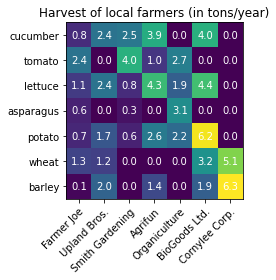

In [59]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

vegetables = ["cucumber", "tomato", "lettuce", "asparagus",
              "potato", "wheat", "barley"]
farmers = ["Farmer Joe", "Upland Bros.", "Smith Gardening",
           "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]

harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])


fig, ax = plt.subplots()
im = ax.imshow(harvest)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(farmers)), labels=farmers)
ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()

In [ ]:
heatscores=[]

for i in range(len(realD)):
    heatscores.append(compNew(realdata_clean_norm_split[0],syndata_clean_norm_split[0], i, test_weights))


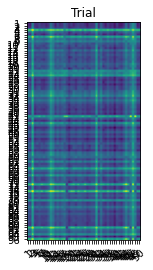

In [84]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

synD = [str(i+1) for i in range(50)]
realD = [str(i+1) for i in range(96)]


fig, ax = plt.subplots()
im = ax.imshow(heatscores)



# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(synD)), labels=synD)
ax.set_yticks(np.arange(len(realD)), labels=realD)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")



ax.set_title("Trial")
plt.show()




In [72]:
heatscores

[[19.036979572208285,
  18.958568364219612,
  21.55066463846599,
  19.2885606428961,
  19.366575082710202,
  19.834975249794578,
  19.16814193241387,
  19.31702550498165,
  19.020374986510106,
  19.419890090602674,
  21.062413782568072,
  20.028550746132403,
  18.98401135014647,
  19.96928071041583,
  19.112656868308115,
  19.477614043749163,
  20.463441282672377,
  19.822217642764528,
  19.145281615828498,
  19.675930542065657,
  19.03649044214169,
  19.416603901666914,
  19.77443944057456,
  19.52499259112771,
  19.638272932504023,
  19.071941836213774,
  18.63279682393194,
  19.420855986991107,
  19.36527832092957,
  19.413725154860273,
  21.64834051444068,
  19.180620296755414,
  20.605660209995666,
  19.36345500713871,
  18.775738141873262,
  19.620206636341756,
  19.14082033636722,
  19.30008879122391,
  18.644776565323447,
  19.64627686241198,
  18.73765492879005,
  18.650870417005535,
  19.137550301822237,
  20.760554857179734,
  19.47012246125758,
  20.899889094120187,
  21.96

In [23]:
compare(realdata_clean_norm,syndata_clean_norm, 0, test_weights)

[19.036979572208285,
 18.958568364219612,
 21.55066463846599,
 19.2885606428961,
 19.366575082710202,
 19.834975249794578,
 19.16814193241387,
 19.31702550498165,
 19.020374986510106,
 19.419890090602674,
 21.062413782568072,
 20.028550746132403,
 18.98401135014647,
 19.96928071041583,
 19.112656868308115,
 19.477614043749163,
 20.463441282672377,
 19.822217642764528,
 19.145281615828498,
 19.675930542065657,
 19.03649044214169,
 19.416603901666914,
 19.77443944057456,
 19.52499259112771,
 19.638272932504023,
 19.071941836213774,
 18.63279682393194,
 19.420855986991107,
 19.36527832092957,
 19.413725154860273,
 21.64834051444068,
 19.180620296755414,
 20.605660209995666,
 19.36345500713871,
 18.775738141873262,
 19.620206636341756,
 19.14082033636722,
 19.30008879122391,
 18.644776565323447,
 19.64627686241198,
 18.73765492879005,
 18.650870417005535,
 19.137550301822237,
 20.760554857179734,
 19.47012246125758,
 20.899889094120187,
 21.96452452585529,
 21.124047343278434,
 18.73105513

Calling each columns with [,:] and then indexing into it with [i]
The columns are being called already but the values within the columns are not being called. That is what this i is doing


We don't need to compare element by element, we can do a vector comparison. 


.* for element by element for 2 vectors


Or use matrix multiplication (might need to transpose weights)




In [14]:
compare_arr = compare(realdata_clean_norm,syndata_clean_norm, 0, test_weights)

In [15]:
#big_comp = []

In [16]:
for i in range(len(realdata_clean_norm)):
    x = compare(realdata_clean_norm,syndata_clean_norm, i, test_weights)
    big_comp.append(x)

#Took 511m 43.3s .....

In [35]:
len(big_comp)

858

In [37]:
import numpy as np

arr = np.array(big_comp)
index_values = []
for i in range(858):
    index_values.append(i)
column_values = []
for i in range(5000):
    column_values.append(i)

In [39]:
df = pd.DataFrame(data = arr, 
                  index = index_values, 
                  columns = column_values)

In [44]:
df.to_csv('data.csv', index=True)

In [17]:
ival = []
for i in range(5000):
    ival.append(i)

In [18]:
min(compare_arr)
compare_arr.index(18.114858335405216)
syndata_clean.iloc[509, :]

Age                                   19.0
Number of sexual partners              2.0
First sexual intercourse              18.0
Num of pregnancies                     4.0
Smokes                                 0.0
Smokes (years)                         0.0
Smokes (packs/year)                    0.0
Hormonal Contraceptives                0.0
Hormonal Contraceptives (years)        2.0
IUD                                    2.0
IUD (years)                            0.0
STDs                                   0.0
STDs (number)                          0.0
STDs:condylomatosis                    0.0
STDs:cervical condylomatosis           0.0
STDs:vaginal condylomatosis            0.0
STDs:vulvo-perineal condylomatosis     0.0
STDs:syphilis                          0.0
STDs:pelvic inflammatory disease       0.0
STDs:genital herpes                   -1.0
STDs:molluscum contagiosum            -1.0
STDs:AIDS                             -1.0
STDs:HIV                              -1.0
STDs:Hepati

In [19]:
"""
#How to access the number from a specific column and row
syndata_clean_norm.loc[0,:"Age"][0]
#Goes through each column iteritvely of the synthetic data row that's closest with the first row of the real data
for i in range(36):
    print("Fake: " + str(syndata.iloc[509][i]) + ". Real: " + str(realdata.iloc[0][i]))
#How to find the minimium of the compare_arr and figure out the location 
min(compare_arr)
compare_arr.index(18.114858335405216)
"""

'\n#How to access the number from a specific column and row\nsyndata_clean_norm.loc[0,:"Age"][0]\n#Goes through each column iteritvely of the synthetic data row that\'s closest with the first row of the real data\nfor i in range(36):\n    print("Fake: " + str(syndata.iloc[509][i]) + ". Real: " + str(realdata.iloc[0][i]))\n#How to find the minimium of the compare_arr and figure out the location \nmin(compare_arr)\ncompare_arr.index(18.114858335405216)\n'

In [20]:
score = 0
for i in range(len(syndata_clean_norm.columns)):
    #print(realdata_clean_naorm.loc[0,:])
    score = score + ((realdata_clean_norm.loc[0,:][i] - syndata_clean_norm.loc[0,:][i])) #* weights[i])

sy = [12,2,12,3,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
re = [18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1,-1,0,0,0,0,0,0,0,0]
ar = [syndata_clean_norm.loc[0,:][i] for i in range(len(syndata.columns))]
ar2 = [realdata_clean_norm.loc[0,:][i] for i in range(len(syndata.columns))]

sum = 0
for i in range(len(sy)):
    sum = sum + abs(ar2[i] - ar[i])
    
assert sum == compare_arr[0], "Not working"

## Ranking
Now that we've made the comparison function, we need a function that creates a threshold that decides if the data is similar enough

In [21]:
def Average(l):
    result = 0
    for i in range(len(l)):
        result = result + l[0]
    result = result/len(l)
    return result

In [22]:
compare_arr_avg = Average(compare_arr)
compare_arr_avg, min(compare_arr), max(compare_arr)

(19.036979572207443, 18.114858335405216, 25.965573953922693)